<a href="https://colab.research.google.com/github/oscarfp6/PracticalDeepLearning/blob/main/MrBean_or_Zapatero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instala las últimas versiones de fastai y gradio
!pip install -U fastai gradio duckduckgo-search

# Importa todo lo necesario de fastai y gradio
from fastai.vision.all import *
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [2]:
from duckduckgo_search import DDGS # <--- Importamos la clase DDGS

In [19]:
# PASO 1: Recopilación de Datos (VERSIÓN ACTUALIZADA)

# --- Nuestra nueva función para buscar imágenes ---
def search_images(term, max_images=100):
    """Busca imágenes en DuckDuckGo usando la nueva API"""
    print(f"Buscando imágenes de: {term}")
    with DDGS() as ddgs:
        # ddgs.images() nos da un "generador", lo convertimos a una lista
        results = list(ddgs.images(
            keywords=term,
            max_results=max_images
        ))
    # Extraemos solo la URL de la imagen de cada resultado
    return [r['image'] for r in results]


# --- El resto del código es casi igual ---
path = Path('zapatero_vs_mrbean')
searches = 'zapatero politician spain', 'mr bean rowan atkinson'
if not path.exists():
    path.mkdir()

# Descarga las imágenes para cada búsqueda usando nuestra nueva función
for o in searches:
    dest = (path/o.split(' ')[0])
    dest.mkdir(exist_ok=True)
    # ¡Aquí usamos nuestra nueva función!
    urls = search_images(o, max_images=50)
    download_images(dest, urls=urls) # Pasamos las URLs a download_images

# Limpiamos las imágenes fallidas (esto no cambia)
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f"Se eliminaron {len(failed)} imágenes fallidas.")

Buscando imágenes de: zapatero politician spain
Buscando imágenes de: mr bean rowan atkinson


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


Se eliminaron 6 imágenes fallidas.


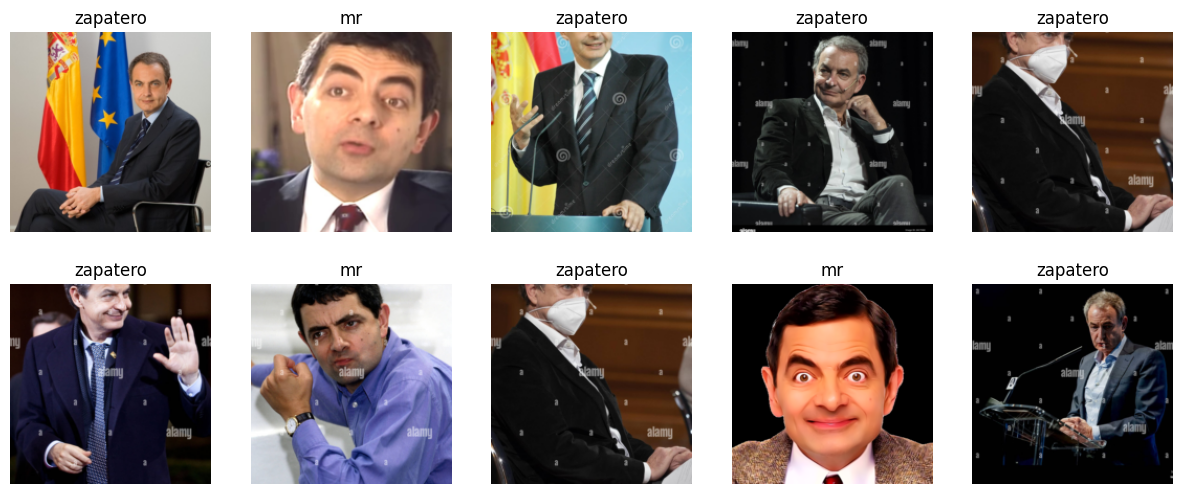

In [20]:
# Creando el "recetario" para nuestros datos con el DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # Entrada: Imagen, Salida: Categoría
    get_items=get_image_files,          # Cómo obtener todos los archivos de imagen
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 20% para validación, con semilla para reproducibilidad
    get_y=parent_label,                 # La etiqueta es el nombre de la carpeta padre
    item_tfms=Resize(192)               # Antes de agrupar, redimensiona cada imagen a 192x192
)

# Creamos los DataLoaders a partir del DataBlock y la ruta
dls = dblock.dataloaders(path)

# Es VITAL comprobar nuestros datos. Mostremos un batch del set de validación.
dls.valid.show_batch(max_n=10, nrows=2)

In [21]:
# Creamos nuestro learner usando una arquitectura resnet18
learn = vision_learner(
    dls,
    resnet18,
    metrics=error_rate # Nuestra métrica será la tasa de error
)

# Hacemos el fine-tuning del modelo
learn.fine_tune(4) # 4 "epochs" o ciclos de entrenamiento

epoch,train_loss,valid_loss,error_rate,time
0,1.712919,1.362802,0.433333,00:06


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.358142,1.175527,0.466667,00:04
1,1.284799,0.578267,0.200000,00:04
2,1.041727,0.284270,0.066667,00:05
3,0.834964,0.187658,0.066667,00:04


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in by

In [22]:
# 1. Exportamos el modelo para usarlo en "inferencia" (predicción)
learn.export('zapatero_mrbean_model.pkl')

# 2. Cargamos el modelo exportado
learn_inf = load_learner('zapatero_mrbean_model.pkl')

# 3. Definimos las etiquetas que Gradio mostrará
labels = learn_inf.dls.vocab

# 4. Creamos la función que se ejecutará con cada predicción
def predict_image(img):
    pred, pred_idx, probs = learn_inf.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

# 5. Lanzamos la interfaz de Gradio
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(height=192, width=192),
    outputs=gr.Label(),
    title="Clasificador de Zapatero vs. Mr. Bean",
    description="Sube una imagen de Zapatero o Mr. Bean para ver quién cree el modelo que es.",
    examples=[str(path/'zapatero'/f) for f in (path/'zapatero').ls()[:2]] + [str(path/'mr'/f) for f in (path/'mr').ls()[:2]]
)

iface.launch(share=True)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c85360f134e84dd74.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [23]:
# Celda para contar imágenes
!ls -1 zapatero_vs_mrbean/zapatero | wc -l
!ls -1 zapatero_vs_mrbean/mr | wc -l

65
85


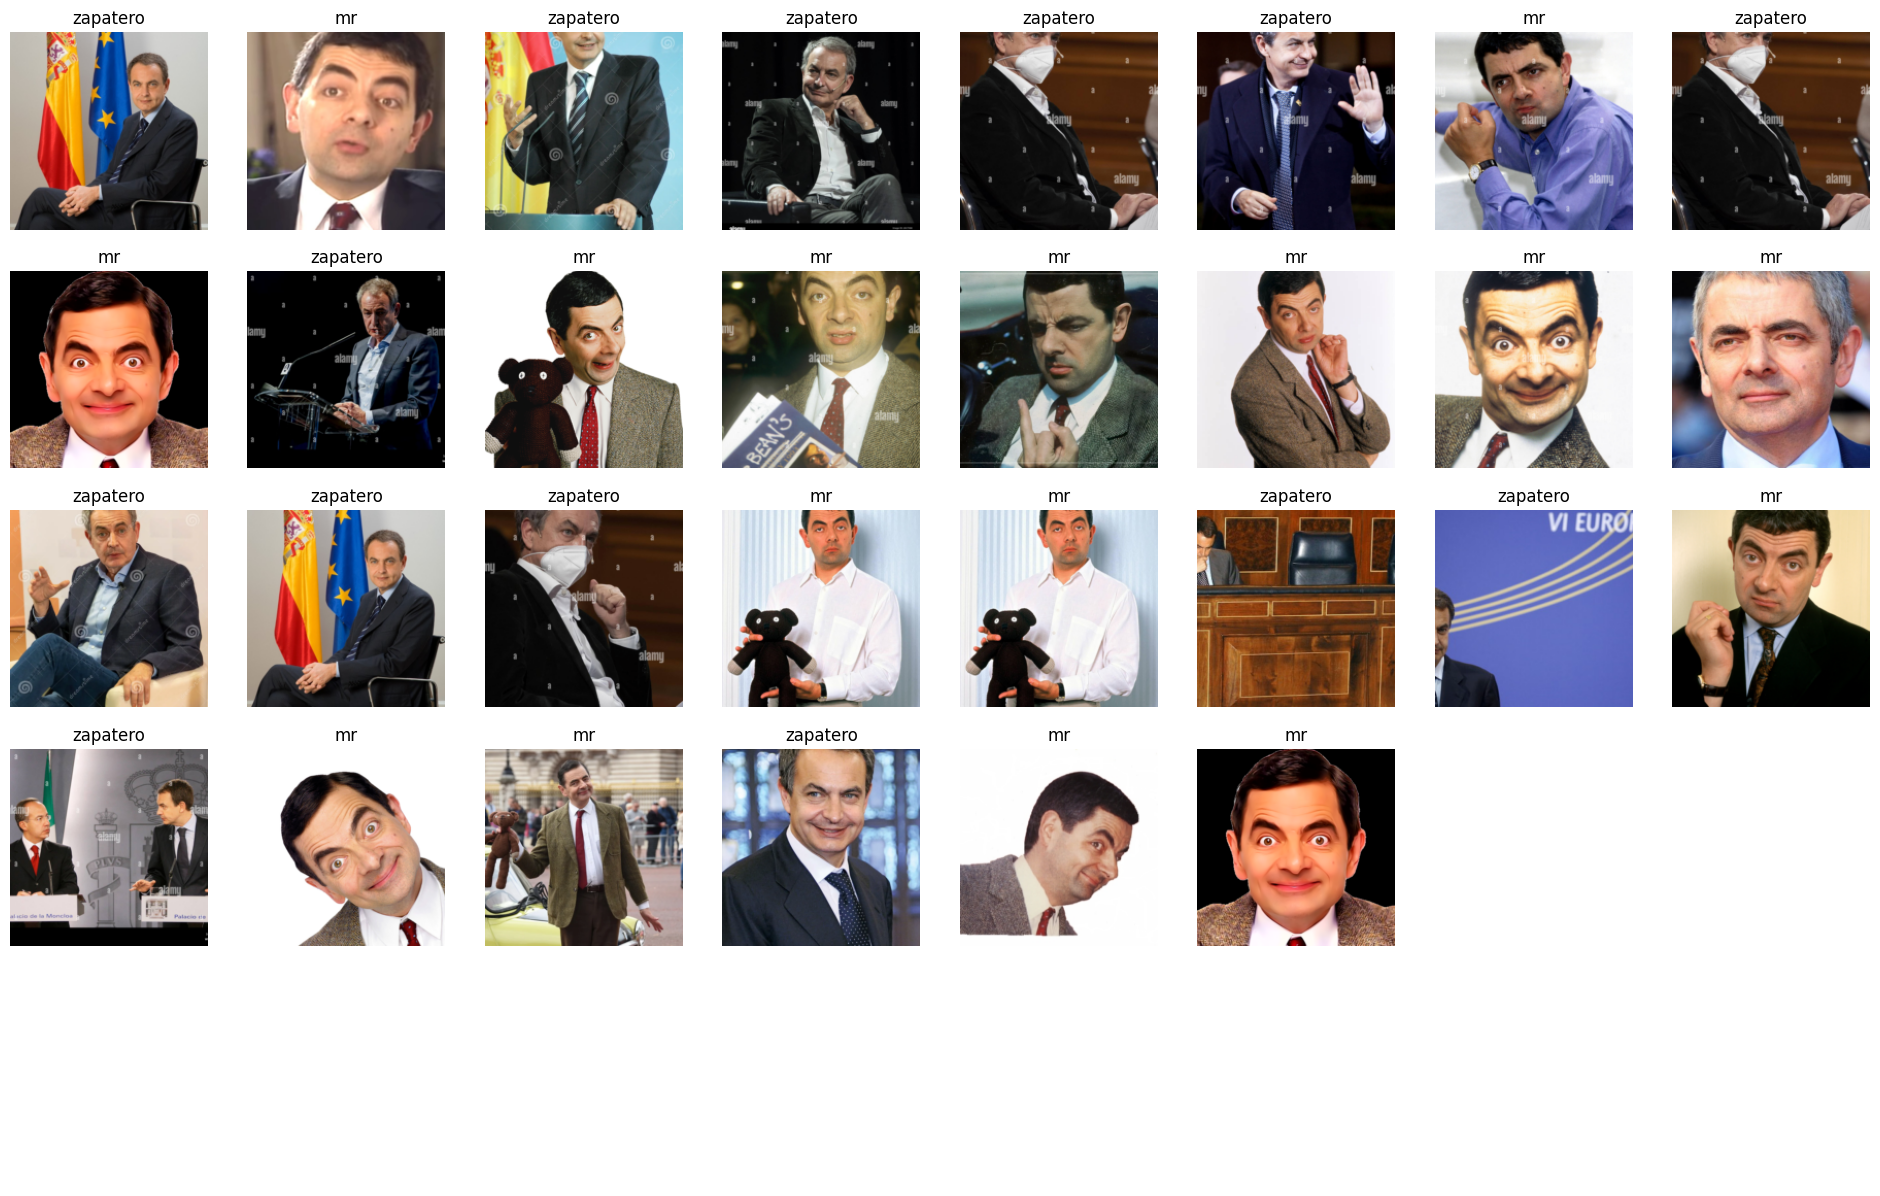

In [24]:
# Celda para verificar etiquetas y datos
dls.valid.show_batch(max_n=40, nrows=5, ncols=8)